+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               100|
|   mean|             39.66|
| stddev|12.032128706597232|
|    min|                18|
|    max|                59|
+-------+------------------+

Outliers in Age:
+-------+----+---+------+------+-------+--------+
|User_ID|Name|Age|Gender|Income|Contact|Location|
+-------+----+---+------+------+-------+--------+
+-------+----+---+------+------+-------+--------+



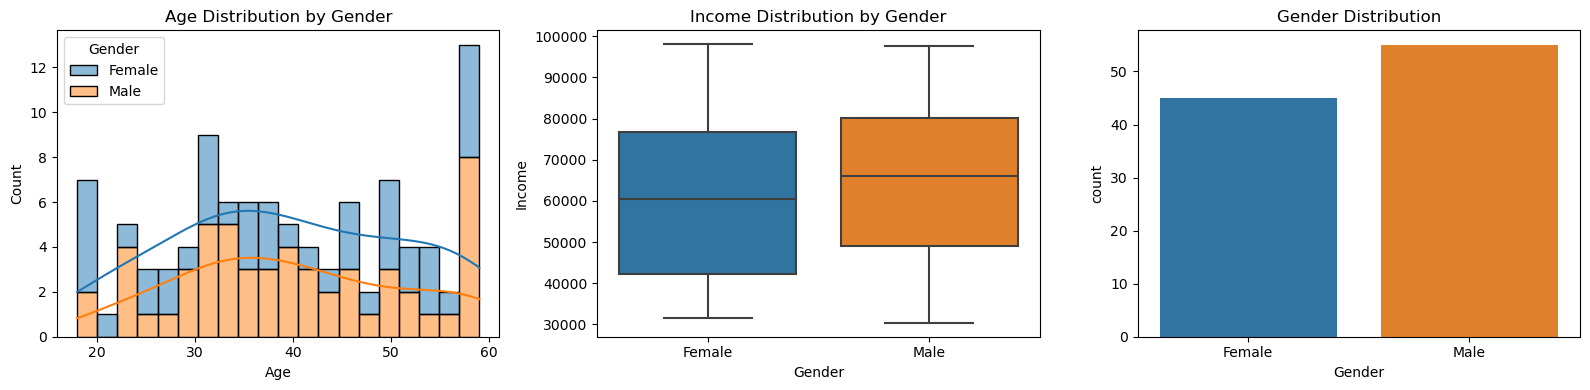

+-------+-----------------+
|summary|            Price|
+-------+-----------------+
|  count|               50|
|   mean|           238.34|
| stddev|145.3659154951913|
|    min|               16|
|    max|              499|
+-------+-----------------+

Outliers in Price:
+----------+------------+--------+-----+
|Product_ID|Product_Name|Category|Price|
+----------+------------+--------+-----+
+----------+------------+--------+-----+



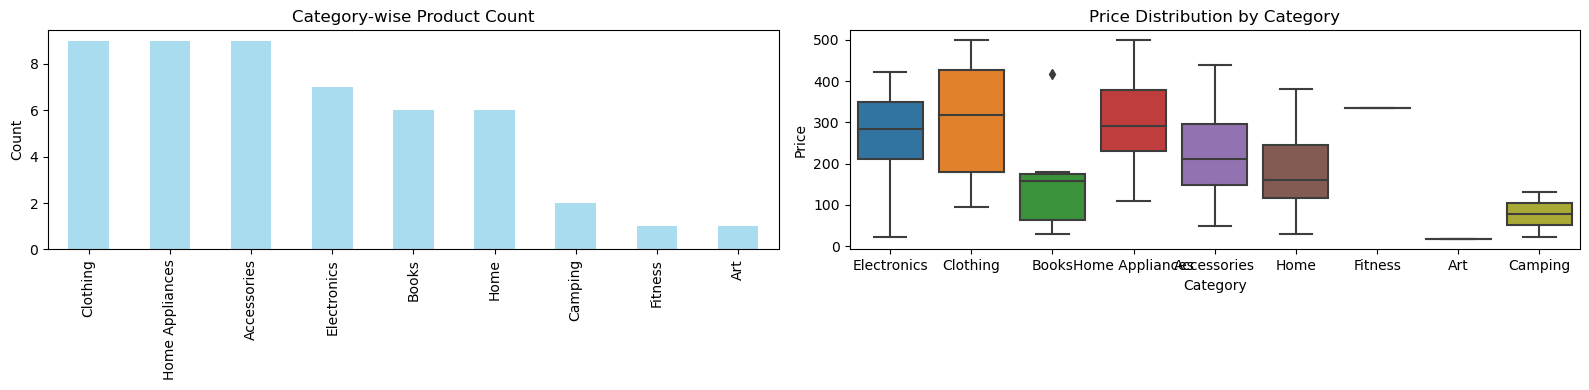

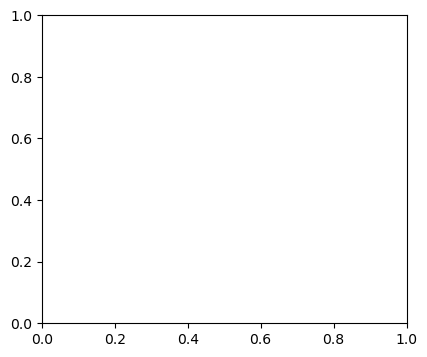

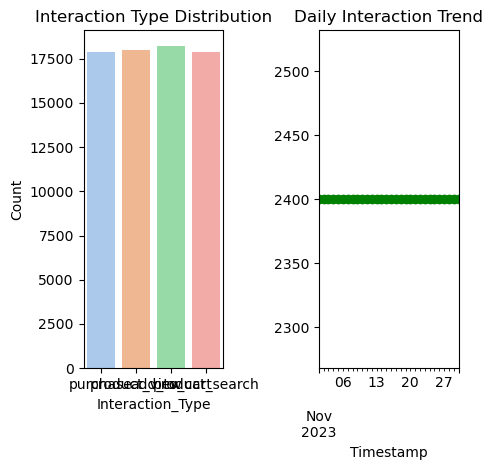

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Load generated data
user_profiles_pd = pd.read_csv('/home/raja/Documents/MS-DATA-SCIENCE/Fall-2023/Big-Data-Project/UserProfiles_data.csv')
product_data_pd = pd.read_csv('/home/raja/Documents/MS-DATA-SCIENCE/Fall-2023/Big-Data-Project/ProductData_data.csv')
user_interactions_pd = pd.read_csv('/home/raja/Documents/MS-DATA-SCIENCE/Fall-2023/Big-Data-Project/UserInteractions_data.csv')

# Convert pandas DataFrames to PySpark DataFrames
spark = SparkSession.builder.getOrCreate()
user_profiles = spark.createDataFrame(user_profiles_pd)
product_data = spark.createDataFrame(product_data_pd)
user_interactions = spark.createDataFrame(user_interactions_pd)

# User Profiles Report
def user_profiles_report():
    global user_profiles  # Declare user_profiles as a global variable
    # Handle null values for numerical attribute 'Age'
    user_profiles = user_profiles.na.fill({'Age': user_profiles.select(F.mean('Age')).collect()[0][0]})

    # Profile numerical attribute 'Age'
    user_profiles.select('Age').describe().show()

    # Explain outliers for numerical attribute 'Age'
    outliers = user_profiles.filter(F.col('Age') > 100)
    print("Outliers in Age:")
    outliers.show()

    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 3, 1)
    sns.histplot(data=user_profiles.toPandas(), x='Age', hue='Gender', bins=20, multiple='stack', kde=True)
    plt.title('Age Distribution by Gender')

    plt.subplot(1, 3, 2)
    sns.boxplot(x='Gender', y='Income', data=user_profiles.toPandas())
    plt.title('Income Distribution by Gender')

    plt.subplot(1, 3, 3)
    sns.countplot(x='Gender', data=user_profiles.toPandas())
    plt.title('Gender Distribution')

    plt.tight_layout()
    plt.show()

# Product Data Report
def product_data_report():
    global product_data  # Declare product_data as a global variable
    # Handle null values for numerical attribute 'Price'
    product_data = product_data.na.fill({'Price': product_data.select(F.mean('Price')).collect()[0][0]})

    # Profile numerical attribute 'Price'
    product_data.select('Price').describe().show()

    # Explain outliers for numerical attribute 'Price'
    outliers = product_data.filter(F.col('Price') > 1000)
    print("Outliers in Price:")
    outliers.show()

    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    category_counts = product_data_pd['Category'].value_counts()
    category_counts.plot(kind='bar', color='skyblue', alpha=0.7)
    plt.title('Category-wise Product Count')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='Category', y='Price', data=product_data_pd)
    plt.title('Price Distribution by Category')

    plt.tight_layout()
    plt.show()

# User Interactions Report
def user_interactions_report():
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 3, 1)
    top_products = (
        user_interactions
        .groupBy('Product_ID')
        .agg(F.count('User_ID').alias('Interaction_Count'))
        .orderBy('Interaction_Count', ascending=False)
        .limit(10)
    )

    top_products_pd = top_products.toPandas()
    top_products_pd.plot(kind='bar', x='Product_ID', y='Interaction_Count', color='salmon', alpha=0.7)
    plt.title('Top 10 Popular Products')

    plt.subplot(1, 3, 2)
    interaction_type_counts = (
        user_interactions
        .groupBy('Interaction_Type')
        .agg(F.count('User_ID').alias('Count'))
    )
    interaction_type_counts_pd = interaction_type_counts.toPandas()
    sns.barplot(x='Interaction_Type', y='Count', data=interaction_type_counts_pd, palette='pastel')
    plt.title('Interaction Type Distribution')

    plt.subplot(1, 3, 3)
    user_interactions_pd['Timestamp'] = pd.to_datetime(user_interactions_pd['Timestamp'])
    user_interactions_pd.set_index('Timestamp')['User_ID'].resample('D').count().plot(kind='line', marker='o', color='green')
    plt.title('Daily Interaction Trend')

    plt.tight_layout()
    plt.show()

# Generate and display enhanced reports
user_profiles_report()
product_data_report()
user_interactions_report()
